In [1]:
import pandas as pd
import networkx as nx

In [2]:
import database.pocket_feature as pf
import database.chemicals as chem

In [3]:
def scaffold_hop(pf_range=[0., 1.], lig_range=[0.,1.]):
    PFG = pf.network(low=pf_range[0], high=pf_range[1])
    LIG = chem.network(low=lig_range[0], high=lig_range[1])
    return scaffold_hop_network(PFG, LIG)
    
def scaffold_hop_network(PFG, LIG):
    SHG = PFG.copy()
    for ligand_0, ligand_1 in PFG.edges:
        try:
            ligand_score = LIG[ligand_0][ligand_1]['weight']
            pf_score = PFG[ligand_0][ligand_1]['weight']

            SHG[ligand_0][ligand_1]['weight'] = pf_score/ligand_score
            SHG[ligand_0][ligand_1]['pf_score'] = pf_score
            SHG[ligand_0][ligand_1]['lig_score'] = ligand_score

        except KeyError:
            SHG.remove_edge(ligand_0, ligand_1)
    return SHG

In [4]:
SHG = scaffold_hop(pf_range=[0.6, 1.], lig_range=[0.,8.])

In [5]:
all_pockets = []
for u,v in SHG.edges:
    pockets = SHG[u][v]['id']
    all_pockets.extend(pockets)
    
structures, ligands = zip( *[i.split('_') for i in set(all_pockets)] )

structures = list(set(structures))
ligands = list(set(ligands))

In [6]:
from networkx.algorithms import bipartite

def projected_graph(Graph):
    nx.set_node_attributes(Graph, bipartite.color(Graph), name='color')

    top = [i for i in Graph.nodes if Graph.nodes[i]['color'] == 1]
    projected = bipartite.overlap_weighted_projected_graph(Graph, top)
    return projected

In [9]:
pdb_uniprot_mapping = pd.read_csv(pdb2uniprot(structures), sep='\t')
PUG = nx.from_pandas_edgelist(pdb_uniprot_mapping, source='From', target='To')

In [10]:
uniprot_filter = projected_graph(PUG)

In [11]:
pdb_pfam_mapping = pfam('')

In [12]:
pdb_pfam_df = pd.DataFrame(pdb_pfam_mapping).groupby('structureId')

In [13]:
agg = []
for i in structures:
    try:
        agg.append( pdb_pfam_df.get_group(i.upper()) )
    except KeyError:
        pass

pfam_df = pd.concat(agg)

In [14]:
pfam_df['structureId'] = pfam_df['structureId'].str.lower()

In [15]:
PfamG = nx.from_pandas_edgelist(pfam_df, source='structureId', target='pfamAcc')
pfam_filter = projected_graph(PfamG)

In [94]:
filtered = SHG.copy()
for u,v in filtered.edges:
    try:
        pdb_0, pdb_1 = [i.split('_')[0] for i in filtered[u][v]['id']]
        if uniprot_filter[pdb_0][pdb_1]['weight'] >= 0.3:
            filtered.remove_edge(u,v)
    except KeyError:
        pass
#         filtered.remove_edge(u,v)

In [95]:
nx.info(filtered)

'Name: \nType: Graph\nNumber of nodes: 592\nNumber of edges: 401\nAverage degree:   1.3547'

In [96]:
from pprint import pprint
sorted_scores = sorted(filtered.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
# pprint(sorted(SHG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10])

In [97]:
from services.pdb import pfam, pdbligand, pdbmolecule
from services.classyfire import classyfire
from services.uniprot import pdb2uniprot
from services.pubchem import get_image

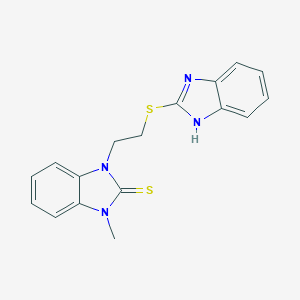

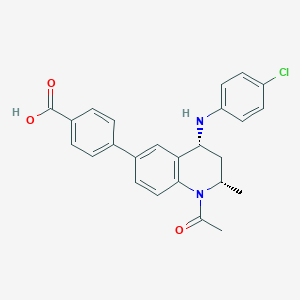

In [98]:
import IPython.display as Disp

# image size can be 'large' or 'small'
image_size = 'large'

idx = 9
edge = sorted_scores[idx]
lig_0 = edge[0]
lig_1 = edge[1]

lig_info = pdbligand( ','.join([lig_0, lig_1]) )
keys = ['chemicalID','chemicalName', 'formula', 'molecularWeight']
classes = []
for info in lig_info:
    inchi = info['InChIKey']
    co_classes = classyfire(inchi)
    classes.append(co_classes)
    txt = [co_classes['direct_parent']['name'], co_classes['description']]
    image = get_image(inchi, image_size=image_size)
#     url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchi}/PNG?image_size={image_size}' 
#     image = requests.get(url).content
    text = '<br>'.join( [info[key].upper() for key in keys] + txt )
    Disp.display( Disp.Image(image), Disp.HTML(text) )

In [99]:
def extract_pdbids(edge_data):
    pdbs = edge_data['id']
    return ','.join([i.split('_')[0] for i in pdbs])

pprint(pdbmolecule(extract_pdbids(edge[2])))

[{'id': '4BJX',
  'polymer': {'Taxonomy': {'id': '9606', 'name': 'Homo sapiens'},
              'chain': {'id': 'A'},
              'entityNr': '1',
              'fragment': {'desc': 'N-TERMINAL BROMODOMAIN, RESIDUES 44-168'},
              'length': '153',
              'macroMolecule': {'accession': {'id': 'O60885'},
                                'name': 'Bromodomain-containing protein 4'},
              'polymerDescription': {'description': 'BROMODOMAIN-CONTAINING '
                                                    'PROTEIN 4'},
              'synonym': {'name': 'PROTEIN HUNK1, BRD4'},
              'type': 'protein',
              'weight': '17939.5'}},
 {'id': '3AQA',
  'polymer': {'Taxonomy': {'id': '9606', 'name': 'Homo sapiens'},
              'chain': [{'id': 'A'}, {'id': 'B'}, {'id': 'C'}],
              'entityNr': '1',
              'fragment': {'desc': 'residues 73-194'},
              'length': '128',
              'macroMolecule': {'accession': {'id': 'P25440'},
   

In [100]:
edge

('BYH',
 '73B',
 {'id': ['4bjx_73B', '3aqa_BYH'],
  'weight': 2.925113299937984,
  'pf_score': 0.72542809838462,
  'lig_score': 0.248})